# This notebook has the commands for creating a horizontal bar chart for the ADHD proportion data within communities

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency,chisquare
import numpy as np

In [61]:
#filtered_data_arms1 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/fluid_ADHDscores_ARMS2_arms1xgb_merged.csv")
#filtered_data_arms2 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/fluid_ADHDscores_ARMS1_arms2xgb_merged.csv")

filtered_data_arms1 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/list_ADHDscores_ARMS2_arms1xgb_merged.csv")
filtered_data_arms2= pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/list_ADHDscores_ARMS1_arms2xgb_merged.csv")
#data_arms1 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_list_ARMS1_merged.csv")
#data_arms2 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_list_ARMS2_merged.csv")

#data_arms1 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_fluid_ARMS1_merged.csv")
#data_arms2 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_fluid_ARMS2_merged.csv")
#filtered_data_arms1
data_arms1

,subjectkey,ADHD1,ADHD2,ADHD3,ADHD4,ADHDcomposite,community
0,NDAR_INV003RTV85,Ctrl,Ctrl,Ctrl,Ctrl,-0.638587,7
1,NDAR_INV007W6H7B,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,7
2,NDAR_INV00BD7VDC,Ctrl,Ctrl,Ctrl,Ctrl,0.907719,5
3,NDAR_INV00HEV6HB,Ctrl,Ctrl,Ctrl,Ctrl,-0.254566,1
4,NDAR_INV00LH735Y,Ctrl,Ctrl,Ctrl,Ctrl,-0.526288,8
...,...,...,...,...,...,...,...
3332,NDAR_INVZY8L7CT1,Ctrl,Ctrl,Ctrl,Ctrl,-0.077094,4
3333,NDAR_INVZYC44GB8,Ctrl,Ctrl,Ctrl,Ctrl,0.251977,2
3334,NDAR_INVZZ05KY5J,Ctrl,Ctrl,Ctrl,Ctrl,0.017155,1
3335,NDAR_INVZZFG6J5U,Ctrl,Ctrl,Ctrl,Ctrl,0.002618,4


In [62]:
#currently keeping all communities, regardless of size, because we are trying to evaluate across the arms with the overfit xgb model

#communities_more_than_100_arms1 = data_arms1['community'].value_counts()[data_arms1['community'].value_counts() > 100].index
#communities_more_than_100_arms2 = data_arms2['community'].value_counts()[data_arms2['community'].value_counts() > 100].index
#filtered_data_arms1 = data_arms1[data_arms1['community'].isin(communities_more_than_100_arms1)]
#filtered_data_arms2 = data_arms2[data_arms2['community'].isin(communities_more_than_100_arms2)]
#data_arms1['community'].value_counts()

In [63]:
#for xgboost communities, add 1
filtered_data_arms1['community'] = filtered_data_arms1['community'] + 1
filtered_data_arms2['community'] = filtered_data_arms2['community'] + 1

In [64]:
#convert community to a categorical variable to ensure proper ordering on the x-axis
filtered_data_arms1.loc[:, 'community'] = pd.Categorical(filtered_data_arms1['community'])
filtered_data_arms2.loc[:, 'community'] = pd.Categorical(filtered_data_arms2['community'])

In [65]:
#function to determine the grouping of all possible adhd label combinations/conditions

def filter_adhd(df, **conditions):
    query = ' & '.join([f"{k} == '{v}'" for k, v in conditions.items()])
    return df.query(query)

In [66]:
#all the possible adhd label combinations/conditions

conditions_arms1 = [
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'}
]

conditions_arms2 = conditions_arms1  # The conditions are the same for arms2

In [67]:
#determine the counts for the condition groups

groups_arms1 = [filtered_data_arms1] + [filter_adhd(filtered_data_arms1, **cond) for cond in conditions_arms1]
groups_arms2 = [filtered_data_arms2] + [filter_adhd(filtered_data_arms2, **cond) for cond in conditions_arms2]
groups_arms1

[            subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
 0     NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275          4
 1     NDAR_INV00NPMHND  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990          2
 2     NDAR_INV01NAYMZH  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990          4
 3     NDAR_INV021403LF  ADHD  ADHD  Ctrl  Ctrl       1.444422          8
 4     NDAR_INV022ZVCT8  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990          5
 ...                ...   ...   ...   ...   ...            ...        ...
 3171  NDAR_INVZZ3P1ZFJ  Ctrl  Ctrl  Ctrl  Ctrl       1.137971          1
 3172  NDAR_INVZZ6ZJ2KY  Ctrl  Ctrl  Ctrl  Ctrl      -0.189392          4
 3173  NDAR_INVZZ81LEEV  Ctrl  Ctrl  Ctrl  Ctrl      -0.189392          1
 3174  NDAR_INVZZZ2ALR6  Ctrl  Ctrl  Ctrl  Ctrl       0.033034          2
 3175  NDAR_INVZZZNB0XC  ADHD  ADHD  ADHD  Ctrl       0.899638          2
 
 [3176 rows x 7 columns],
             subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
 0     NDA

In [68]:
#better display of the counts

for group in groups_arms1:
    if not group.empty:
        print(group.head(1))
        print(len(group))

#outputs are in order: total, no adhd, adhd1, adhd2, adhd3, adhd4

         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275          4
3176
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275          4
2928
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
158  NDAR_INV20CNYBBC  ADHD  Ctrl  Ctrl  Ctrl       1.741991          3
7
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
3  NDAR_INV021403LF  ADHD  ADHD  Ctrl  Ctrl       1.444422          8
90
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
48  NDAR_INV0JAG7BGC  ADHD  ADHD  ADHD  Ctrl       1.936428          4
55
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
72  NDAR_INV0UMM15GY  ADHD  ADHD  ADHD  ADHD       3.435609          1
96


In [69]:
for group in groups_arms2:
    if not group.empty:
        print(group.head(1))
        print(len(group))

         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV003RTV85  Ctrl  Ctrl  Ctrl  Ctrl      -0.638587          3
3146
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV003RTV85  Ctrl  Ctrl  Ctrl  Ctrl      -0.638587          3
2931
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
316  NDAR_INV2DTHE81G  ADHD  Ctrl  Ctrl  Ctrl        2.79549          6
14
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
23  NDAR_INV05LGG3GZ  ADHD  ADHD  Ctrl  Ctrl       1.067142          1
83
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
103  NDAR_INV0UPRUMA1  ADHD  ADHD  ADHD  Ctrl       0.098208          2
42
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
6  NDAR_INV00U4FTRU  ADHD  ADHD  ADHD  ADHD       2.920183          2
76


In [70]:
#functions to summarize the label counts into one dataframe

def summarize_by_label(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'ADHD'].assign(ADHD=label)

def summarize_by_label_ctrl(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'Ctrl'].assign(ADHD='Ctrl')

In [71]:
summary_data_arms1_ctrl_adhd1 = summarize_by_label_ctrl(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD1 = summarize_by_label(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD2 = summarize_by_label(filtered_data_arms1, 'ADHD2')
summary_data_arms1_ADHD3 = summarize_by_label(filtered_data_arms1, 'ADHD3')
summary_data_arms1_ADHD4 = summarize_by_label(filtered_data_arms1, 'ADHD4')
summary_data_arms1_ADHD2

,community,ADHD2,count,ADHD
0,1,ADHD,58,ADHD2
2,2,ADHD,51,ADHD2
4,3,ADHD,8,ADHD2
6,4,ADHD,58,ADHD2
8,5,ADHD,24,ADHD2
10,6,ADHD,15,ADHD2
12,7,ADHD,14,ADHD2
14,8,ADHD,4,ADHD2
16,9,ADHD,9,ADHD2


In [72]:
summary_data_arms2_ctrl_adhd1 = summarize_by_label_ctrl(filtered_data_arms2, 'ADHD1')
summary_data_arms2_ADHD1 = summarize_by_label(filtered_data_arms2, 'ADHD1')
summary_data_arms2_ADHD2 = summarize_by_label(filtered_data_arms2, 'ADHD2')
summary_data_arms2_ADHD3 = summarize_by_label(filtered_data_arms2, 'ADHD3')
summary_data_arms2_ADHD4 = summarize_by_label(filtered_data_arms2, 'ADHD4')

In [73]:
total_count = (len(filtered_data_arms1[(filtered_data_arms1["community"]==1)]))
ADHD1_count = (len((filtered_data_arms1[(filtered_data_arms1["ADHD1"]=="ADHD") & (filtered_data_arms1["community"]==1)])))
ADHD2_count = (len((filtered_data_arms1[(filtered_data_arms1["ADHD2"]=="ADHD") & (filtered_data_arms1["community"]==1)])))
ADHD3_count = (len((filtered_data_arms1[(filtered_data_arms1["ADHD3"]=="ADHD") & (filtered_data_arms1["community"]==1)])))
ADHD4_count = (len((filtered_data_arms1[(filtered_data_arms1["ADHD4"]=="ADHD") & (filtered_data_arms1["community"]==1)])))
num_ADHD4 = ADHD4_count
num_ADHD3 = ADHD3_count - ADHD4_count
num_ADHD2 = ADHD2_count - ADHD3_count
num_ADHD1 = ADHD1_count - ADHD2_count 
ctrl_count = total_count - num_ADHD4 - num_ADHD3 - num_ADHD2 - num_ADHD1
num_ADHD3

11

In [74]:
filtered_data_arms1

,subjectkey,ADHD1,ADHD2,ADHD3,ADHD4,ADHDcomposite,community
0,NDAR_INV00J52GPG,Ctrl,Ctrl,Ctrl,Ctrl,0.364275,4
1,NDAR_INV00NPMHND,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,2
2,NDAR_INV01NAYMZH,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,4
3,NDAR_INV021403LF,ADHD,ADHD,Ctrl,Ctrl,1.444422,8
4,NDAR_INV022ZVCT8,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,5
...,...,...,...,...,...,...,...
3171,NDAR_INVZZ3P1ZFJ,Ctrl,Ctrl,Ctrl,Ctrl,1.137971,1
3172,NDAR_INVZZ6ZJ2KY,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,4
3173,NDAR_INVZZ81LEEV,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,1
3174,NDAR_INVZZZ2ALR6,Ctrl,Ctrl,Ctrl,Ctrl,0.033034,2


In [75]:
def get_adhd_counts(df, community):
    total_count = len(df[df["community"] == community])

    adhd_counts = {}
    for i in range(1,5):
        adhd_counts[f"ADHD{i}"] = len(df[(df[f"ADHD{i}"] == "ADHD") & (df["community"] == community)])

    num_adhd = {f"num_ADHD{i}": 0 for i in range(1,5)}
    num_adhd["num_ADHD4"] = adhd_counts["ADHD4"]
    for i in range(3,0,-1):
        num_adhd[f"num_ADHD{i}"] = adhd_counts[f"ADHD{i}"] - adhd_counts[f"ADHD{i+1}"]

    ctrl_count = total_count - sum(num_adhd.values())

    result = [
        {"community": community, "ADHD_label": "Ctrl", "count": ctrl_count}
    ]
    result.extend([
        {"community": community, "ADHD_label": f"ADHD{i}", "count": num_adhd[f"num_ADHD{i}"]}
        for i in range(1,5)
    ])

    return result

In [76]:
communities_arms1 = filtered_data_arms1["community"].unique()
communities_arms2 = filtered_data_arms2["community"].unique()
communities_arms1

array([4, 2, 8, 5, 1, 6, 7, 3, 9])

In [77]:
all_results_arms1 = []
all_results_arms2 = []
for community in communities_arms1:
    all_results_arms1.extend(get_adhd_counts(filtered_data_arms1, community))
for community in communities_arms2:
    all_results_arms2.extend(get_adhd_counts(filtered_data_arms2, community))

result_df_arms1 = pd.DataFrame(all_results_arms1)
result_df_arms2 = pd.DataFrame(all_results_arms2)
result_df_arms1

,community,ADHD_label,count
0,4,Ctrl,390
1,4,ADHD1,3
2,4,ADHD2,16
3,4,ADHD3,11
4,4,ADHD4,31
5,2,Ctrl,631
6,2,ADHD1,0
7,2,ADHD2,16
8,2,ADHD3,13
9,2,ADHD4,22


In [78]:
#calculate the relevant proportions and add it as a new column
proportion_data_arms1 = result_df_arms1
proportion_data_arms2 = result_df_arms2

proportion_data_arms1['proportion'] = result_df_arms1.groupby('community', observed=False)['count'].transform(lambda x: x / x.sum())
proportion_data_arms2['proportion'] = result_df_arms2.groupby('community', observed=False)['count'].transform(lambda x: x / x.sum())
proportion_data_arms1

,community,ADHD_label,count,proportion
0,4,Ctrl,390,0.864745
1,4,ADHD1,3,0.006652
2,4,ADHD2,16,0.035477
3,4,ADHD3,11,0.024390
4,4,ADHD4,31,0.068736
5,2,Ctrl,631,0.925220
6,2,ADHD1,0,0.000000
7,2,ADHD2,16,0.023460
8,2,ADHD3,13,0.019062
9,2,ADHD4,22,0.032258


## Set the dataframe of interest here

In [92]:
#pivot the data to prepare it for visualization

df_pivot = proportion_data_arms2.pivot(index='community', columns='ADHD_label', values='proportion')
df_pivot = df_pivot.sort_index()
df_pivot

ADHD_label,ADHD1,ADHD2,ADHD3,ADHD4,Ctrl
community,,,,,
1,0.001193,0.021480,0.008353,0.014320,0.954654
2,0.000000,0.028436,0.014218,0.030806,0.926540
3,0.002174,0.015217,0.015217,0.021739,0.945652
4,0.007797,0.035088,0.017544,0.031189,0.908382
5,0.016760,0.050279,0.016760,0.053073,0.863128
6,0.004866,0.014599,0.012165,0.012165,0.956204
7,0.000000,0.027778,0.013889,0.006944,0.951389


## Also set the dataframe of interest here

In [91]:
df_pivot_counts = proportion_data_arms2.pivot(index='community', columns='ADHD_label', values='count')
df_pivot_counts = df_pivot_counts.sort_index()
df_pivot_counts

ADHD_label,ADHD1,ADHD2,ADHD3,ADHD4,Ctrl
community,,,,,
1,1,18,7,12,800
2,0,12,6,13,391
3,1,7,7,10,435
4,4,18,9,16,466
5,6,18,6,19,309
6,2,6,5,5,393
7,0,4,2,1,137


In [93]:
df_pivot_counts_no_ctrl = df_pivot_counts.drop(columns='Ctrl')
df_pivot_counts_no_ctrl

ADHD_label,ADHD1,ADHD2,ADHD3,ADHD4
community,,,,
1,1,18,7,12
2,0,12,6,13
3,1,7,7,10
4,4,18,9,16
5,6,18,6,19
6,2,6,5,5
7,0,4,2,1


In [94]:
adhd_columns = ['ADHD1', 'ADHD2', 'ADHD3', 'ADHD4']
df_adhd_total = df_pivot_counts.copy()
df_adhd_total['ADHD_total'] = df_adhd_total[adhd_columns].sum(axis=1)
df_adhd_total

ADHD_label,ADHD1,ADHD2,ADHD3,ADHD4,Ctrl,ADHD_total
community,,,,,,
1,1,18,7,12,800,38
2,0,12,6,13,391,31
3,1,7,7,10,435,25
4,4,18,9,16,466,47
5,6,18,6,19,309,49
6,2,6,5,5,393,18
7,0,4,2,1,137,7


In [95]:
df_adhd_totals = df_adhd_total.drop(columns=adhd_columns)
df_adhd_totals

ADHD_label,Ctrl,ADHD_total
community,,
1,800,38
2,391,31
3,435,25
4,466,47
5,309,49
6,393,18
7,137,7


# Create Plot. Make sure figure is named properly

<Figure size 1200x1000 with 0 Axes>

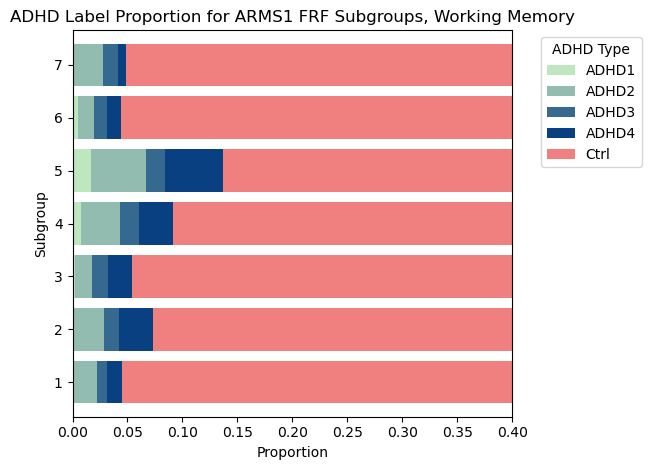

In [96]:
#plot the horizontal bar chart of the adhd label proportion data
import matplotlib.colors as mcolors

# Create a colormap
n_categories = len(df_pivot.columns)
gradient_color = plt.cm.GnBu
start_color = gradient_color(0.3)
end_color = gradient_color(1.0)
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_GnBu", [start_color, end_color], N=n_categories)
gradient_range = [custom_cmap(1. * i / (n_categories - 2)) for i in range(n_categories - 1)]

last_column_color = 'lightcoral'
color_range = gradient_range + [last_column_color]

#create the horizontal stacked bar chart
plt.figure(figsize=(12, 10))
ax = df_pivot.plot(kind='barh', stacked=True, width=0.8, color=color_range)
plt.xlim(0, 0.4)

#customize the plot
#plt.title('ADHD Label Proportion for ARMS1 XGBoost Subgroups with ARMS2 data, Working Memory')
plt.title('ADHD Label Proportion for ARMS1 FRF Subgroups, Working Memory')
plt.xlabel('Proportion')
plt.ylabel('Subgroup')

#remove the legend from its current position
plt.legend().remove()

#add a legend to the right of the plot
plt.legend(title='ADHD Type', bbox_to_anchor=(1.05, 1), loc='upper left')

#add percentage labels on the bars
#for c in ax.containers:
#    ax.bar_label(c, fmt='%.2f%%', label_type='center')

#adjust layout and display the plot
plt.tight_layout()
#plt.savefig('./list_adhd_proportions_arms1xgb_arms2data_remake.png', dpi=300, bbox_inches='tight')
plt.show()

## Chi2 statistics. Set dataframe here

In [97]:
df_pivot_counts = df_adhd_totals
df_pivot_counts

ADHD_label,Ctrl,ADHD_total
community,,
1,800,38
2,391,31
3,435,25
4,466,47
5,309,49
6,393,18
7,137,7


In [98]:
df_pivot_totals = df_pivot_counts.copy()
df_pivot_totals['Total'] = df_pivot_totals.sum(axis=1)
totals = df_pivot_totals.sum()
df_pivot_totals.loc['Total'] = totals
print(df_pivot_totals)

ADHD_label  Ctrl  ADHD_total  Total
community                          
1            800          38    838
2            391          31    422
3            435          25    460
4            466          47    513
5            309          49    358
6            393          18    411
7            137           7    144
Total       2931         215   3146


In [99]:
dof_test = df_pivot_counts.size - sum(df_pivot_counts.shape) + df_pivot_counts.ndim - 1
dof_test

6

In [100]:
# Perform chi-square test of homogeneity
chi2, p_value, dof, expected = chi2_contingency(df_pivot_counts)

print(f"Chi-square statistic: {chi2:.5g}")
print(f"p-value: {p_value:.5g}")
print(f"\nDegrees of freedom: {dof}")
print("\nContingency table (observed frequencies):")
print(df_pivot_counts)
print("\nExpected frequencies:")
print(pd.DataFrame(expected, 
                  index=df_pivot_counts.index, 
                  columns=df_pivot_counts.columns))

#Interpreting the results:

#If p-value < 0.05, reject null hypothesis: there is evidence that sex_at_birth differs across subgroups
#If p-value ≥ 0.05, fail to reject the null hypothesis: there is no evidence sex_at_birth differs across subgroups

#You might also want to look at the standardized residuals to see which specific cells contribute most to any significant difference:

Chi-square statistic: 44.089
p-value: 7.0966e-08

Degrees of freedom: 6

Contingency table (observed frequencies):
ADHD_label  Ctrl  ADHD_total
community                   
1            800          38
2            391          31
3            435          25
4            466          47
5            309          49
6            393          18
7            137           7

Expected frequencies:
ADHD_label        Ctrl  ADHD_total
community                         
1           780.730451   57.269549
2           393.160203   28.839797
3           428.563255   31.436745
4           477.941195   35.058805
5           333.534011   24.465989
6           382.911952   28.088048
7           134.158932    9.841068


In [101]:
# do something like this row by row for each community
# statistic, pvalue = chisquare(f_obs, f_exp)
expected_df = pd.DataFrame(expected, index=df_pivot_counts.index, columns=df_pivot_counts.columns)
#expected_df = expected_df.round().astype(int)
#expected_df = expected_df.astype(float)
#expected_df = expected_df.map(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
print(expected_df)

ADHD_label        Ctrl  ADHD_total
community                         
1           780.730451   57.269549
2           393.160203   28.839797
3           428.563255   31.436745
4           477.941195   35.058805
5           333.534011   24.465989
6           382.911952   28.088048
7           134.158932    9.841068


In [102]:
#need to do this over with the expected counts, not expected proportions!!
for i in range(df_pivot_counts.shape[0]):
    observed_indv = df_pivot_counts.iloc[i,:]
    expected_indv = expected_df.iloc[i,:]
    chi2_indv, p_indv = chisquare(observed_indv, expected_indv)
    print(f"Community {i+1}:")
    print(f"Observed values: {observed_indv.tolist()}")
    print(f"Expected values: {expected_indv.tolist()}")
    print(f"Chi-square statistic: {chi2_indv:.5g}")
    print(f"p-value: {p_indv:.5g}")
    print()
#build CI contrast to see which one is different. pairwise CI of the contrast
# visualize this difference between the groups (talk to Michael)

Community 1:
Observed values: [800, 38]
Expected values: [780.730451366815, 57.269548633184996]
Chi-square statistic: 6.9592
p-value: 0.0083387

Community 2:
Observed values: [391, 31]
Expected values: [393.1602034329307, 28.839796567069293]
Chi-square statistic: 0.17368
p-value: 0.67687

Community 3:
Observed values: [435, 25]
Expected values: [428.5632549268913, 31.43674507310871]
Chi-square statistic: 1.4146
p-value: 0.23429

Community 4:
Observed values: [466, 47]
Expected values: [477.9411951684679, 35.05880483153211]
Chi-square statistic: 4.3656
p-value: 0.036672

Community 5:
Observed values: [309, 49]
Expected values: [333.5340114431024, 24.46598855689765]
Chi-square statistic: 26.407
p-value: 2.7655e-07

Community 6:
Observed values: [393, 18]
Expected values: [382.91195168467897, 28.088048315321043]
Chi-square statistic: 3.889
p-value: 0.048604

Community 7:
Observed values: [137, 7]
Expected values: [134.1589319771138, 9.841068022886205]
Chi-square statistic: 0.88037
p-value

# repeating process for adhd severity

In [301]:
df_pivot_counts_no_ctrl

ADHD_label,ADHD1,ADHD2,ADHD3,ADHD4
community,,,,
1,1,18,7,12
2,0,12,6,13
3,1,7,7,10
4,4,18,9,16
5,6,18,6,19
6,2,6,5,5
7,0,4,2,1


In [302]:
df_pivot_sev_totals = df_pivot_counts_no_ctrl.copy()
df_pivot_sev_totals['Total'] = df_pivot_sev_totals.sum(axis=1)
totals_sev = df_pivot_sev_totals.sum()
df_pivot_sev_totals.loc['Total'] = totals_sev
print(df_pivot_sev_totals)

ADHD_label  ADHD1  ADHD2  ADHD3  ADHD4  Total
community                                    
1               1     18      7     12     38
2               0     12      6     13     31
3               1      7      7     10     25
4               4     18      9     16     47
5               6     18      6     19     49
6               2      6      5      5     18
7               0      4      2      1      7
Total          14     83     42     76    215


In [303]:
dof_test2 = df_pivot_counts_no_ctrl.size - sum(df_pivot_counts_no_ctrl.shape) + df_pivot_counts_no_ctrl.ndim - 1
dof_test2

18

In [304]:
# Perform chi-square test of homogeneity
chi2_sev, p_value_sev, dof_sev, expected_sev = chi2_contingency(df_pivot_counts_no_ctrl)

print(f"Chi-square statistic: {chi2_sev:.5g}")
print(f"p-value: {p_value_sev:.5g}")
print(f"\nDegrees of freedom: {dof_sev}")
print("\nContingency table (observed frequencies):")
print(df_pivot_counts_no_ctrl)
print("\nExpected frequencies:")
print(pd.DataFrame(expected_sev, 
                  index=df_pivot_counts_no_ctrl.index, 
                  columns=df_pivot_counts_no_ctrl.columns))

#Interpreting the results:

#If p-value < 0.05, reject null hypothesis: there is evidence that sex_at_birth differs across subgroups
#If p-value ≥ 0.05, fail to reject the null hypothesis: there is no evidence sex_at_birth differs across subgroups

#You might also want to look at the standardized residuals to see which specific cells contribute most to any significant difference:

Chi-square statistic: 14.464
p-value: 0.69841

Degrees of freedom: 18

Contingency table (observed frequencies):
ADHD_label  ADHD1  ADHD2  ADHD3  ADHD4
community                             
1               1     18      7     12
2               0     12      6     13
3               1      7      7     10
4               4     18      9     16
5               6     18      6     19
6               2      6      5      5
7               0      4      2      1

Expected frequencies:
ADHD_label     ADHD1      ADHD2     ADHD3      ADHD4
community                                           
1           2.474419  14.669767  7.423256  13.432558
2           2.018605  11.967442  6.055814  10.958140
3           1.627907   9.651163  4.883721   8.837209
4           3.060465  18.144186  9.181395  16.613953
5           3.190698  18.916279  9.572093  17.320930
6           1.172093   6.948837  3.516279   6.362791
7           0.455814   2.702326  1.367442   2.474419


In [305]:
# do something like this row by row for each community
# statistic, pvalue = chisquare(f_obs, f_exp)
expected_df_sev = pd.DataFrame(expected_sev, index=df_pivot_counts_no_ctrl.index, columns=df_pivot_counts_no_ctrl.columns)
print(expected_df_sev)

ADHD_label     ADHD1      ADHD2     ADHD3      ADHD4
community                                           
1           2.474419  14.669767  7.423256  13.432558
2           2.018605  11.967442  6.055814  10.958140
3           1.627907   9.651163  4.883721   8.837209
4           3.060465  18.144186  9.181395  16.613953
5           3.190698  18.916279  9.572093  17.320930
6           1.172093   6.948837  3.516279   6.362791
7           0.455814   2.702326  1.367442   2.474419


In [306]:
#need to do this over with the expected counts, not expected proportions!!
for i in range(df_pivot_counts_no_ctrl.shape[0]):
    observed_indv_sev = df_pivot_counts_no_ctrl.iloc[i,:]
    expected_indv_sev = expected_df_sev.iloc[i,:]
    chi2_indv_sev, p_indv_sev = chisquare(observed_indv_sev, expected_indv_sev)
    print(f"Community {i+1}:")
    print(f"Observed values: {observed_indv_sev.tolist()}")
    print(f"Expected values: {expected_indv_sev.tolist()}")
    print(f"Chi-square statistic: {chi2_indv_sev:.5g}")
    print(f"p-value: {p_indv_sev:.5g}")
    print()
#build CI contrast to see which one is different. pairwise CI of the contrast
# visualize this difference between the groups (talk to Michael)

Community 1:
Observed values: [1, 18, 7, 12]
Expected values: [2.474418604651163, 14.669767441860465, 7.423255813953489, 13.432558139534883]
Chi-square statistic: 1.8115
p-value: 0.61244

Community 2:
Observed values: [0, 12, 6, 13]
Expected values: [2.0186046511627906, 11.967441860465117, 6.055813953488372, 10.95813953488372]
Chi-square statistic: 2.3997
p-value: 0.4937

Community 3:
Observed values: [1, 7, 7, 10]
Expected values: [1.627906976744186, 9.651162790697674, 4.883720930232558, 8.837209302325581]
Chi-square statistic: 2.0405
p-value: 0.56404

Community 4:
Observed values: [4, 18, 9, 16]
Expected values: [3.0604651162790697, 18.144186046511628, 9.18139534883721, 16.613953488372093]
Chi-square statistic: 0.31585
p-value: 0.95702

Community 5:
Observed values: [6, 18, 6, 19]
Expected values: [3.1906976744186046, 18.91627906976744, 9.572093023255814, 17.32093023255814]
Chi-square statistic: 4.0137
p-value: 0.25999

Community 6:
Observed values: [2, 6, 5, 5]
Expected values: [1.1